# 2.5. JAGGS

In [2]:
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Metropolis Hastings using PyMC3

Consider the following model:

$$y_i | \mu \sim N(\mu, 1), ~~~~ i = 1, ..., n$$
$$\mu \sim t(0, 1, 1)$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8805461431700915, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


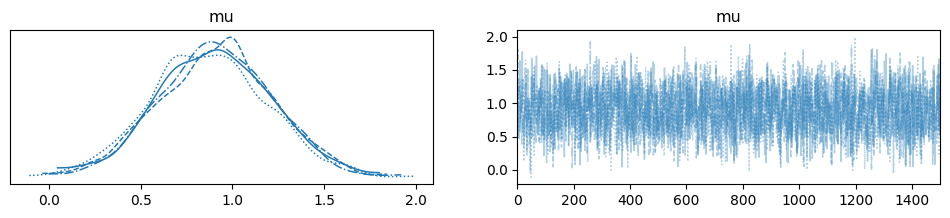

In [3]:
# Specify the data
y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9])
n = len(y)

# Specify the model
with pm.Model() as model:
    mu = pm.StudentT('mu', nu=1, mu=0, sigma=1)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=1, observed=y)

# Run the MCMC sampler
with model:
    trace = pm.sample(1500, return_inferencedata=False)

# Post processing
az.plot_trace(trace)
plt.show()

In [4]:
az.summary( trace, round_to=4)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.8975,0.312,0.3379,1.5134,0.0064,0.0045,2377.8415,4038.0337,1.0022


## Gibbs Sampling: Conditionally Conjugate Prior Example with Normal Likelihood


Let's look at our model. Here's the full conditional update for the mean $\mu$:
$$N\left( \mu | \frac{n \bar{y}/\sigma^2 + \mu_0 / \sigma_0^2}{n/\sigma^2 + 1/\sigma_0^2}, \frac{1}{n/\sigma^2 + 1/\sigma_0^2}  \right)$$


And here's the full conditional update for the variance $\sigma^2$:

$$IG \left( \sigma^2 | \nu_0 + \frac{n}{2}, \beta_0 + \frac{ \sum_{i=1}^n ( y_i - \mu )^2 }{2}  \right)$$

We will need to write functions to simulate from these conditional updates


In [9]:
def update_mu(n, ybar, sig2, mu_0, sig2_0):
    sig2_1 = 1.0 / (n/sig2 + 1.0/sig2_0)
    mu_1 = sig2_1 * (n*ybar/sig2 + mu_0/sig2_0)
    return stats.norm.rvs(loc=mu_1, scale=np.sqrt(sig2_1), size=1)[0]

def update_sig2(n, y, mu, nu_0, beta_0):
    nu_1 = nu_0 + n/2.0
    sumsq = np.sum((y - mu)**2)
    beta_1 = beta_0 + sumsq/2.0
    return stats.invgamma.rvs(nu_1, scale=beta_1, size=1)[0]

def gibbs(y, n_iter, init, prior):
    ybar = np.mean(y)
    n = len(y)
    
    mu_out = np.empty(n_iter)
    sig2_out = np.empty(n_iter)
    
    mu_curr = init['mu']
    
    ## Gibbs sampler
    for i in range(n_iter):
        sig2_curr = update_sig2(n, y, mu_curr, prior['nu_0'], prior['beta_0'])
        sig2_out[i] = sig2_curr
        
        mu_curr = update_mu(n, ybar, sig2_curr, prior['mu_0'], prior['sig2_0'])
        mu_out[i] = mu_curr
    
    return pd.DataFrame(np.column_stack([mu_out, sig2_out]), columns=["mu", "sig2"])

def plot_posterior( posterior, ybar ):
    mu_posterior = posterior
    kde = stats.gaussian_kde(mu_posterior)
    x_values = np.linspace(min(mu_posterior) - 1, max(mu_posterior) + 1, 1000)
    density_values = kde(x_values)


    # change the size of the plot
    plt.figure(figsize=(6, 5))
    plt.plot(x_values, density_values)
    
    # get the x-axis
    x = np.linspace(-1.0, 2.5, 100)
    
    # make a dashed line
    plt.plot(x, stats.t.pdf(x, df=1, loc=0, scale=1), color='red', linewidth=2, linestyle='dashed');
    plt.scatter( ybar, 0, color='red', marker='o', zorder=2)
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimate')
    plt.show()
    
def plot_hist(y, ybar):
    plt.figure(figsize=(6, 5))
    # plot the histogram of the data with no colors on the shape       
    plt.hist(y, bins=5, density=True, color='blue', alpha=0.5, edgecolor='black');
    plt.xlim(-1.0, 2.5)
    # add the data points
    plt.scatter( y, np.zeros(n), color='blue', marker='o', zorder=2)
    # add the sample mean
    plt.scatter( ybar, 0, color='red', marker='o', zorder=2)
    # add to the plot a prior consisting of a t-distribution with 3 degrees of freedom

    # get the x-axis
    x = np.linspace(-1.0, 2.5, 100)
    # make a dashed line
    plt.plot(x, stats.t.pdf(x, df=1, loc=0, scale=1), color='red', linewidth=2, linestyle='dashed');
    # add a legend saying that the red line is the prior
    plt.legend(["Sample data points", 'Sample mean', "Prior: t-student distribution"], loc='upper left')

def compute_statistics(posterior, list_vars):
    # Get the number of chains and the length of each chain
    n_chains, chain_length = posterior.shape

    # Compute the mean and standard deviation
    mean = np.mean(posterior)
    std = np.std(posterior)
    
    # Compute the mean of each chain
    chain_means = np.mean(posterior, axis=1)

    # Compute the mean of all chains
    grand_mean = np.mean(chain_means)

    # Compute the between-chain variance
    B = chain_length / (n_chains - 1) * np.sum((chain_means - grand_mean)**2)

    # Compute the within-chain variance for each chain
    W = 1 / (n_chains * (chain_length - 1)) * np.sum((posterior - np.expand_dims(chain_means, axis=1))**2)

    # Compute the estimated variance of the parameter of interest
    V_hat = (chain_length - 1) / chain_length * W + 1 / chain_length * B

    # Compute the R-hat statistic
    R_hat = np.sqrt(V_hat / W)

    # compute the 95% credible interval
    ci = stats.norm.interval(0.95, loc=mean, scale=std)
    
    # Compute the Effective Sample Size (ESS)
    autocorr = np.correlate(posterior.mu - mean.mu, posterior.sig2 - mean.sig2, mode='full')
    
    # this takes the second half of the autocorrelation function, which contains the
    # the autocorrelation values for negative lags, while the second half contains the 
    # autocorrelation values for positive lags
    autocorr = autocorr[autocorr.size // 2:]
    
    # effective sample size
    ess = len(posterior) / (1 + 2*np.sum(autocorr) / np.var(posterior))
    
    # bulk effective sample size
    ess_bulk = len(posterior) / (1 + 2*np.sum(autocorr[:int(len(autocorr)/2)]) / np.var(posterior))
    
    # tail effective sample size
    ess_tail = len(posterior) / (1 + 2*np.sum(autocorr[int(len(autocorr)/2):]) / np.var(posterior))

    columns = ["n_chains", ]
    
    res = []
    for var in posterior.shape[1]:
        
        

    print("Number of chains: {}".format(n_chains))
    print("Chain length: {}".format(chain_length))
    print("Mean_mu: {}".format(mean["mu"]))
    print("Mean_sig2: {}".format(mean["sig2"]))
    print("Standard deviation_mu: {}".format(std["mu"]))
    print("Standard deviation_sig2: {}".format(std["sig2"]))
    #print("Chain means: {}".format(chain_means))
    print("Grand mean: {}".format(grand_mean))
    print("Between-chain variance: {}".format(B))
    print("Within-chain variance: {}".format(W))
    print("Estimated variance: {}".format(V_hat))
    print("R-hat: {}".format(R_hat))
    print("95% credible interval: {}".format(ci))
    print("Effective Sample Size: {}".format(ess))
    print("Bulk Effective Sample Size: {}".format(ess_bulk))
    print("Tail Effective Sample Size: {}".format(ess_tail))
    
    return [n_chains, chain_length, mean["mu"], mean["sig2"], std["mu"], std["sig2"], 
            grand_mean, B, W, V_hat, R_hat, ci, autocorr, ess, ess_bulk, ess_tail]  #pd.DataFrame(results, columns = [])
    

In [14]:
posterior.shape

(1000, 2)

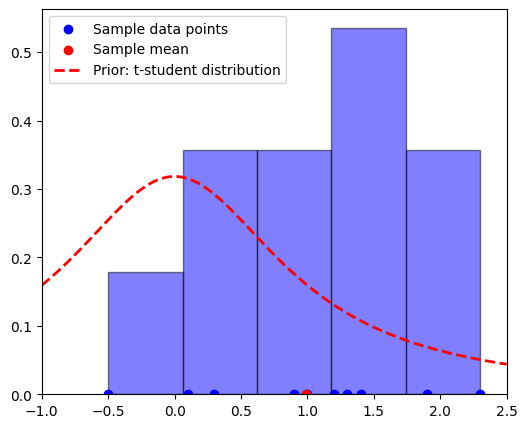

In [10]:
# setting up the program

y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9])
ybar = np.mean(y)
n = len(y)

prior = { "mu_0" : 0.0, 
          "sig2_0" : 1.0, 
          "n_0" : 2.0,
          "s2_0" : 1.0,
          }
prior["nu_0"] = prior["n_0"] / 2.0
prior["beta_0"] = prior["n_0"] * (prior["s2_0"] / 2.0)

plot_hist(y, ybar)


In [11]:
# set seed
np.random.seed(53)

init = { "mu" : 0.0 }

n_iter = 1000

posterior = gibbs(y, n_iter, init, prior)
posterior_dict = {}
posterior_dict["mu"] = posterior["mu"].values
posterior_dict["sig2"] = posterior["sig2"].values
posterior


,mu,sig2
0,0.057140,2.533886
1,1.623251,1.288321
2,1.303944,1.194861
3,0.964858,0.639731
4,0.692301,0.720335
...,...,...
995,0.377140,0.380810
996,0.727683,1.009150
997,0.668815,0.548091
998,0.892005,0.616804


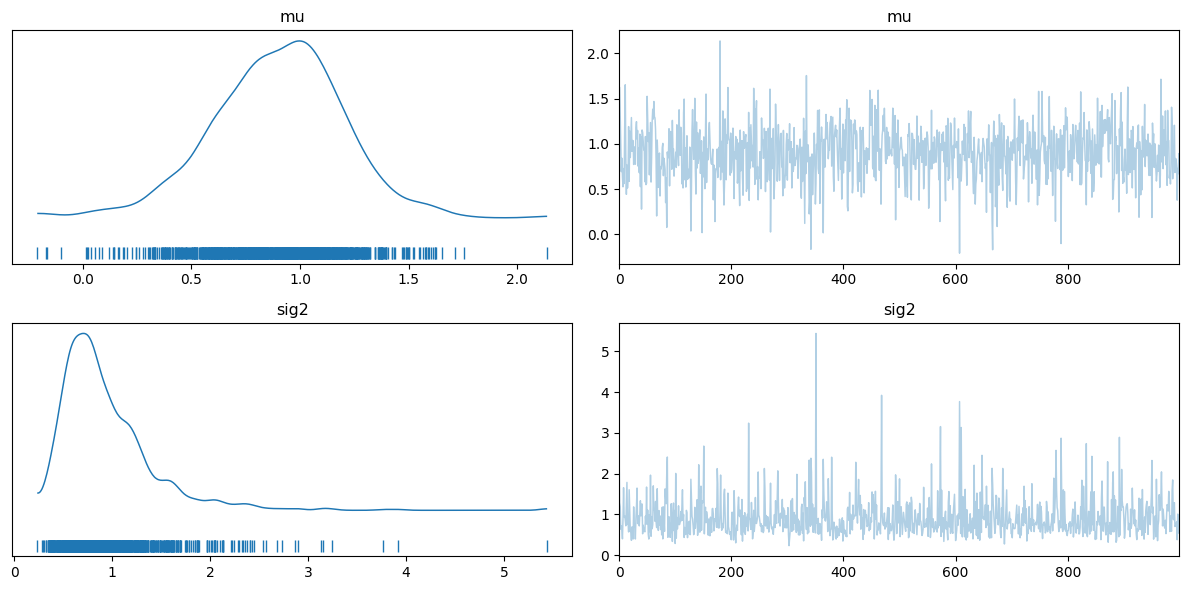

In [12]:
az.plot_trace(posterior_dict, figsize=(12, 6), rug=True)
plt.tight_layout()

In [13]:
gibbs_stats = compute_statistics( posterior)
gibbs_stats

Number of chains: 1000
Chain length: 2
Mean_mu: 0.894777755494747
Mean_sig2: 0.93669281242087
Standard deviation_mu: 0.2987406801235498
Standard deviation_sig2: 0.47953436877846956
Grand mean: 0.915735283957808
Between-chain variance: 0.13062962826555277
Within-chain variance: mu      0.094789
sig2    0.094789
dtype: float64
Estimated variance: mu      0.112709
sig2    0.112709
dtype: float64
R-hat: mu      1.090437
sig2    1.090437
dtype: float64
95% credible interval: (array([ 0.30925678, -0.00317728]), array([1.48029873, 1.8765629 ]))
Effective Sample Size: mu     -3.523015
sig2   -9.128180
dtype: float64
Bulk Effective Sample Size: mu     -2.528702
sig2   -6.541590
dtype: float64
Tail Effective Sample Size: mu       8.880049
sig2    22.564616
dtype: float64


[1000,
 2,
 0.894777755494747,
 0.93669281242087,
 0.2987406801235498,
 0.47953436877846956,
 0.915735283957808,
 0.13062962826555277,
 mu      0.094789
 sig2    0.094789
 dtype: float64,
 mu      0.112709
 sig2    0.112709
 dtype: float64,
 mu      1.090437
 sig2    1.090437
 dtype: float64,
 (array([ 0.30925678, -0.00317728]), array([1.48029873, 1.8765629 ])),
 array([-2.91006038e+01,  1.22230309e-01,  2.50083617e-01,  6.12326064e+00,
         8.03438587e+00,  5.96232424e+00, -5.84171716e-01, -3.10186833e+00,
        -7.31327685e+00,  5.30658231e+00,  3.48592986e+00,  2.16189521e-01,
        -3.57035339e+00, -6.39119374e+00,  3.13065057e+00, -1.03706744e+00,
        -5.84596016e+00, -1.40841224e+00, -8.60805425e-01, -3.05673634e-01,
         4.86952305e+00,  8.47772521e+00, -3.03106855e+00,  4.27348413e+00,
         3.50990781e+00, -7.03674073e+00,  6.43904398e+00, -3.66791843e+00,
         1.86596225e+00,  2.93450089e+00,  4.35847651e+00,  1.93995733e-01,
        -3.11345168e+00,  1

In [119]:

print( "Rhat: \n" + str(gibbs_stats["r_hat"]))
print("--------------------")
print("Vhat: \n" + str(gibbs_stats["v_hat"]))
print("--------------------")
print("What: \n" + str(gibbs_stats["w_hat"]))
print("--------------------")



TypeError: list indices must be integers or slices, not str

In [83]:
az.summary( posterior_dict, round_to=4)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.8948,0.2989,0.3056,1.4043,0.0100,0.0071,874.5358,910.5049,NaN
sig2,0.9367,0.4798,0.2771,1.7021,0.0162,0.0115,866.3047,979.2293,NaN
